In [1]:
from pathlib import Path

import PIL
import pytorch_lightning as pl
import torch
from PIL import ImageOps
from pytorch_lightning.loggers import WandbLogger
from pytorch_toolbelt.losses import BinaryFocalLoss
from ternausnet.models import UNet11
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [2]:
PROJECT_ROOT = Path('/home/maria/Documents/Image_segmentation/cats_and_dogs_segmentation/')
BATCH_SIZE = 16
GPUS = 1

## Preparing dataset

In [13]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # idk if it helps in training, ToTensor already normalizes the image
    # transforms.Normalize((0.5,), (0.5,))
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # can't use ToTensor, because it normalizes the image
    transforms.PILToTensor(),
    # classes: 1, 2, 3 (1 - animal, 2 - background, 3 - border of animal? hard to find) -> 0, 1, 1
    lambda x: torch.div(x.type(torch.FloatTensor), 2, rounding_mode='trunc')
])

dataset = datasets.OxfordIIITPet(
            root=PROJECT_ROOT / 'data' / '01_raw',
            target_types='segmentation',
            download=True,
            transform=transform,
            target_transform=target_transform);

In [14]:
dataset

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: /home/maria/Documents/Image_segmentation/cats_and_dogs_segmentation/data/01_raw
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Target transform: Compose(
                      Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
                      PILToTensor()
                      <function <lambda> at 0x7f7b682cb910>
                  )

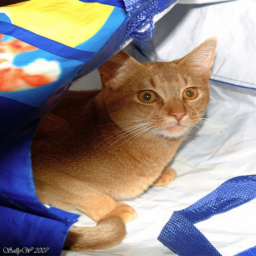

In [15]:
PIL.ImageOps.autocontrast(transforms.ToPILImage()(dataset[0][0]))

/tmp/ipykernel_64940/3952525785.py:13: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  lambda x: x.type(torch.FloatTensor) // 2


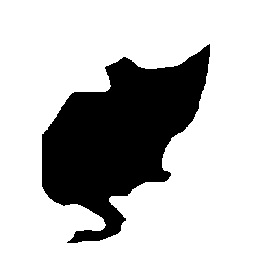

In [6]:
PIL.ImageOps.autocontrast(transforms.ToPILImage()(dataset[0][1][0]))

In [7]:
dataset_lenght = len(dataset)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [int(dataset_lenght * 0.7), int(dataset_lenght * 0.2), int(dataset_lenght * 0.1)])

In [8]:
dataloaders = {type:
    DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    for type, dataset in zip(['train', 'val', 'test'], [train_set, val_set, test_set])
}

## Model

In [25]:
# https://github.com/ternaus/people_segmentation/blob/master/people_segmentation/train.py
class UNetLit(pl.LightningModule):

    def __init__(self, config):
        super().__init__()

        self.lr = config["lr"]
        self.eps = config["eps"]

        self.save_hyperparameters()

        self.model =  UNet11(pretrained=True)
        self.loss_fn = BinaryFocalLoss()

    def forward(self, x):
        outputs = self.model(x)
        return outputs

    def configure_optimizers(self):
        optimizer = Adam(self.model.parameters(), lr=self.lr, eps=self.eps)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.loss_fn(outputs, y)
        self.log("train_loss", loss)
        self.log("train_acc", (outputs == y).float().mean())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.loss_fn(outputs, y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.loss_fn(outputs, y)
        self.log("test_loss", loss)
        return loss

## Train

In [10]:
config = {
    "lr": 0.001,
    "eps": 1e-8
}

In [26]:
model = UNetLit(config)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath='data/06_models/',
    filename='model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min')

trainer = pl.Trainer(logger=WandbLogger(save_dir=f"logs/", project='instance_segmentation'),
                     gpus=GPUS, max_epochs=10, callbacks=[checkpoint_callback])

trainer.fit(model, dataloaders['train'], dataloaders['val'])

wandb: Currently logged in as: maria_wyrzykowska. Use `wandb login --relogin` to force relogin
wandb: WARNING Path logs/wandb/ wasn't writable, using system temp directory.
wandb: WARNING Path logs/wandb/ wasn't writable, using system temp directory


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | model   | UNet11          | 22.9 M
1 | loss_fn | BinaryFocalLoss | 0     
--------------------------------------------
22.9 M    Trainable params
0         Non-trainable params
22.9 M    Total params
91.710    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/maria/Documents/Image_segmentation/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/maria/Documents/Image_segmentation/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/tmp/ipykernel_64940/3952525785.py:13: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negativ

Training: 0it [00:00, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 3.82 GiB total capacity; 1.85 GiB already allocated; 180.88 MiB free; 2.06 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF